In [1]:
# Base packages
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import time

#Figure setting
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=100
plt.rcParams['figure.figsize']=[8,6]

# Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# JGAE modules
from scgae import SCGAE
from preprocessing import load_data, get_adj, normalize
from utils import *
from losses import *
from clustering import louvain, computeCentroids

In [2]:
count, idents = load_data(33, norm = "scanpy")

/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:
/opt/anaconda3/lib/python3.7/site-packages/scanpy/utils.py:618: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:
/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
count.shape

(2240, 2500)

In [4]:
starttime = time.time()
adj, adj_n = get_adj(count, k=35, pca=30)
print("Calculated adjacency matrix.")
model = SCGAE(count, adj=adj, adj_n=adj_n, hidden_dim=128, latent_dim=10, decA="DBL", layer_enc = "GAT")
model.pre_train(epochs = 80, W_a=0.5, W_x=1, W_d=0, min_dist=3, cut_loss=False, max_dist=20, info_step=10, lr=2e-3)
endtime = time.time()
endtime - starttime 

Calculated adjacency matrix.
Epoch 10  X_rec_loss: 0.9009358   A_rec_loss: 0.015625
Epoch 20  X_rec_loss: 0.8645293   A_rec_loss: 0.015625
Epoch 30  X_rec_loss: 0.8373357   A_rec_loss: 0.015625
Epoch 40  X_rec_loss: 0.8188666   A_rec_loss: 0.015625
Epoch 50  X_rec_loss: 0.80694515   A_rec_loss: 0.015625
Epoch 60  X_rec_loss: 0.7989361   A_rec_loss: 0.015625
Epoch 70  X_rec_loss: 0.7921027   A_rec_loss: 0.015625
Epoch 80  X_rec_loss: 0.78541   A_rec_loss: 0.015625
Pre_train Finish!


46.62691593170166

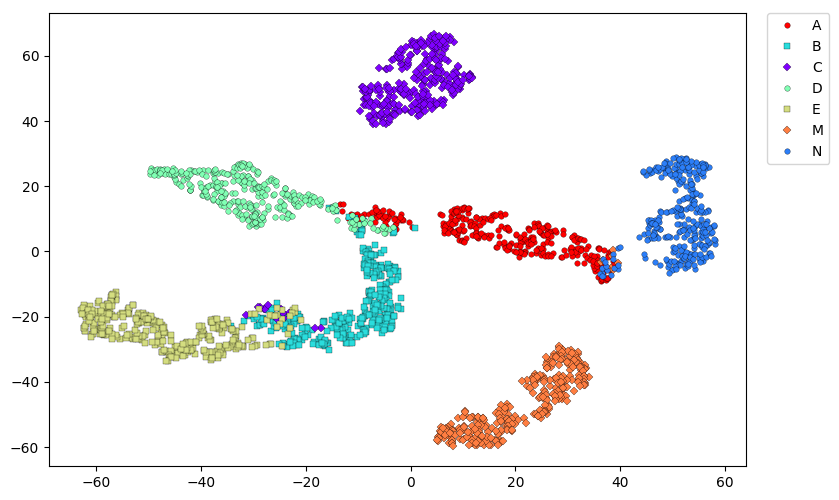

In [5]:
Y = model.embedding(count, adj_n)
Y2 = dotsne(Y, dim=2, ran=2)
myscatter(Y2, idents) #80epoch

## Alter-train

In [8]:
from sklearn.cluster import SpectralClustering
l = SpectralClustering(n_clusters=7,affinity="precomputed", assign_labels="discretize",random_state=0).fit_predict(adj)
centers = computeCentroids(Y, l, 7)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


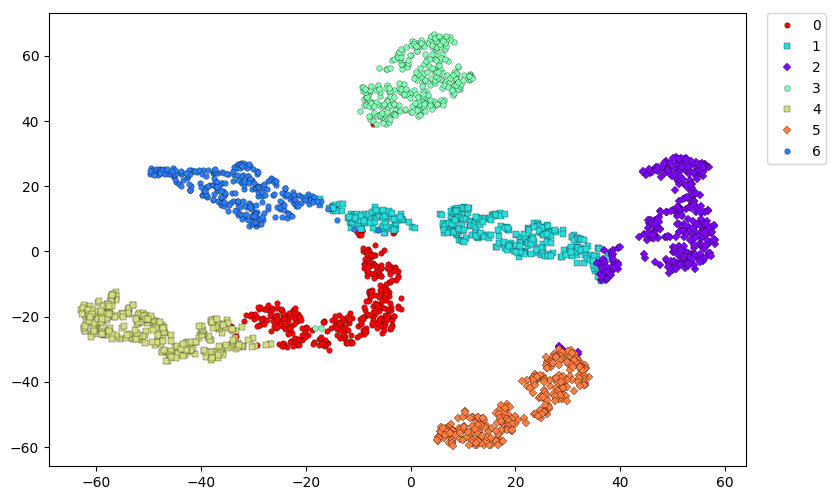

In [9]:
myscatter(Y2, l)

In [11]:
model.alt_train(epochs=38, info_step=5, W_c=1.2, W_a=0.5, W_x=1, n_update=8, centers=centers, lr=5e-4)

Epoch 0  X_rec_loss:  0.7847257  A_rec_loss:  0.015625  cluster_loss:  0.34589902
Epoch 5  X_rec_loss:  0.78686357  A_rec_loss:  0.015625  cluster_loss:  0.19590253
Epoch 10  X_rec_loss:  0.7914699  A_rec_loss:  0.015625  cluster_loss:  0.2678411
Epoch 15  X_rec_loss:  0.7995081  A_rec_loss:  0.015625  cluster_loss:  0.16912785
Epoch 20  X_rec_loss:  0.807626  A_rec_loss:  0.015625  cluster_loss:  0.21380788
Epoch 25  X_rec_loss:  0.81258327  A_rec_loss:  0.015625  cluster_loss:  0.23971269
Epoch 30  X_rec_loss:  0.815843  A_rec_loss:  0.015625  cluster_loss:  0.18582319
Epoch 35  X_rec_loss:  0.8186979  A_rec_loss:  0.015625  cluster_loss:  0.20157422


In [12]:
Ynew = model.embedding(count, adj_n)

In [13]:
Y2new = dotsne(Ynew, dim=2)

In [14]:
l = model.get_label(count, adj_n)

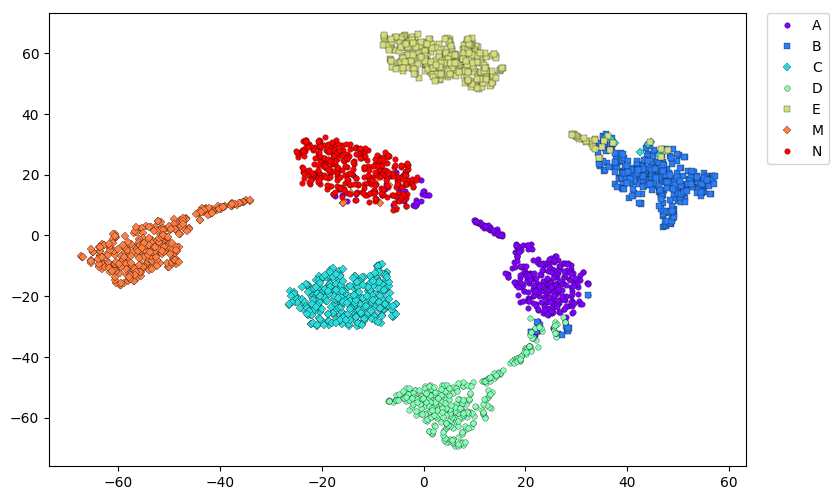

In [15]:
myscatter(Y2new, idents,ran=False)

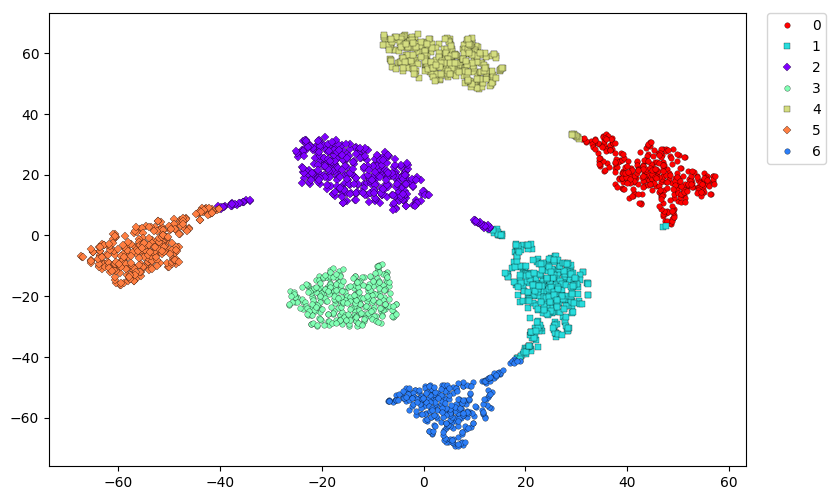

In [16]:
myscatter(Y2new, l)